# BERT Embedding Practice
# Introduction of Text Mining - Assignment 3
### B05704007 國企四 賴昱瑋
---

In [1]:
# pip install keras_bert --user

In [2]:
import numpy as np
import pandas as pd
import os
import scipy
from sklearn import metrics

### Function for lowercasing documents and Filter out English stopwords

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import casual_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = nltk.corpus.stopwords.words('english')
stop_words = stop_words + [",", ".", "'", "'s", "'re", "n't", "ll", "?", "_", "-", "`", "``", "''", "--", "__", "___", "'ll", ";", "'is", ":"]

def filter_tolow(stop_words, doc): # Lowercase everything & Filter out English stopwords
    tokens_doc = word_tokenize(doc.lower())
    new_doc = [x for x in tokens_doc if x not in stop_words]
    
    for i in range(len(new_doc)):
        new_doc[i] = WordNetLemmatizer().lemmatize(new_doc[i])
        new_doc[i] = WordNetLemmatizer().lemmatize(new_doc[i], pos = "a")
        new_doc[i] = WordNetLemmatizer().lemmatize(new_doc[i], pos = "v")

    new_doc = ' '.join(new_doc)
    return new_doc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\willy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\willy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\willy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### From PA-1: Open files

In [4]:
os.chdir('/PA1-data')

doc_list = ['']*1095
doc_count = 0

for file_id in range(0, 1095):
    with open(os.path.join(os.getcwd(), "{}.txt".format(file_id + 1)), 'r') as f: # open in read only mode
        doc = ' '.join(f.readlines())
        # doc = filter_tolow(stop_words, doc)
        doc_list[doc_count] = doc
        doc_count += 1

---
## 1. Classification with BERT
### (1) Extra the [[CLS]] embedding

In [5]:
import keras_bert
from keras_bert import extract_embeddings
from keras_bert import load_vocabulary
from keras_bert import Tokenizer

model_path = '/uncased_L-12_H-768_A-12'
dict_path = '/uncased_L-12_H-768_A-12/vocab.txt'
config_path = '/uncased_L-12_H-768_A-12/bert_config.json'
checkpoint_path = '/uncased_L-12_H-768_A-12/bert_model.ckpt'

bert_token_dict = load_vocabulary(dict_path)
bert_tokenizer = Tokenizer(bert_token_dict)

In [6]:
from keras_bert import load_trained_model_from_checkpoint
model = load_trained_model_from_checkpoint(config_path, checkpoint_path)

In [7]:
# Get [CLS]
embeddings_CLS  = ['']*1095
for i in range(0, 1095):
    print(i)

    tokens = bert_tokenizer.tokenize(doc_list[i])
    indices, segments = bert_tokenizer.encode(doc_list[i], max_len = 512)

    predicts = model.predict([np.array([indices]), np.array([segments])])[0]
    embeddings_CLS[i] = predicts[0].tolist()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

---
# 2. SVM Model: Linear Kernal
### (1) Seperate data for model building (with results on labels) and prediction (no results on labels)
#### Read labels for docs

In [8]:
labels = [0]*1095

# os.chdir('')
training = pd.read_table('training.txt', header = None, sep = ' ')

categories = [i for i in range(1, 14)]
for i in range(0, len(training.index)):
    clist = training.iloc[i]
    clist = clist[1:].tolist()
    clist = [x for x in clist if str(x) != 'nan']
    for j in clist:
        labels[int(j) - 1] = i + 1

In [9]:

x_model = []
x_predict = []
y_model = []
y_predict = []

for i in range(0, len(labels)):
    if labels[i] != 0:
        x_model.append(embeddings_CLS[i])
        y_model.append(labels[i])
    elif labels[i] == 0:
        x_predict.append(embeddings_CLS[i])
        y_predict.append(labels[i])

# Seperate model building dataset to training set and testing set
from sklearn.model_selection import train_test_split
x_model_train, x_model_test, y_model_train, y_model_test = train_test_split(x_model, y_model, test_size = 0.1)


### (2) SVM Linear kernel method

In [10]:
from sklearn.svm import SVC

SVM_model = SVC(kernel = 'linear', C = 1.0)
SVM_model.fit(x_model_train, y_model_train)
y_score = SVM_model.decision_function(x_model_test)

In [11]:
predict_results = []
expect_results = []

expect_results.extend(y_model_test)
predict_results.extend(SVM_model.predict(x_model_test))

print(expect_results,'\n', predict_results)

[6, 6, 11, 3, 9, 9, 10, 12, 5, 10, 5, 7, 13, 13, 7, 12, 8, 6, 8, 11] 
 [6, 6, 11, 3, 9, 9, 10, 12, 5, 10, 5, 7, 13, 13, 7, 12, 8, 6, 8, 11]


In [12]:
print(metrics.classification_report(predict_results, expect_results))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Make predicition for all data

In [13]:
SCMlinear_results = []
index = [x for x in range(len(labels))]

SCMlinear_results.extend(SVM_model.predict(embeddings_CLS))
SCMlinear_results = pd.DataFrame(
    {
        'Id': [x + 1 for x in range(len(labels))],
        'Value': SCMlinear_results
    })

print(SCMlinear_results)

        Id  Value
0        1      2
1        2      2
2        3      2
3        4      2
4        5      2
...    ...    ...
1090  1091      6
1091  1092      6
1092  1093      6
1093  1094      6
1094  1095      9

[1095 rows x 2 columns]


### (4) Draw Curve

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_model_test_list = [0] * len(y_model_test)
for i in range(len(y_model_test)):
    y_model_test_list[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int)
    y_model_test_list[i][int(y_model_test[i]) - 1] = 1
y_model_test_list = pd.DataFrame(y_model_test_list)

# Precision and Recall For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(13): # 13 classes
    precision[i], recall[i], _ = precision_recall_curve(y_model_test_list.iloc[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_model_test_list.iloc[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_model_test_list.to_numpy().ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_model_test_list, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

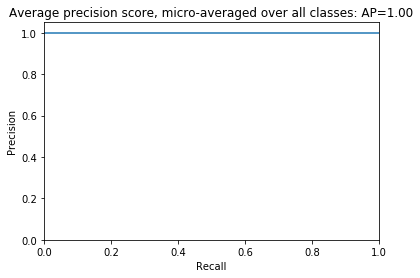

In [15]:
# Plot the Precision Recall Curve
import matplotlib.pyplot as plt

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))